In [2]:
import dLuxToliman as dlT
import dLux as dl
import dLux.utils as dlu
import matplotlib.pyplot as plt
import jax.numpy as np

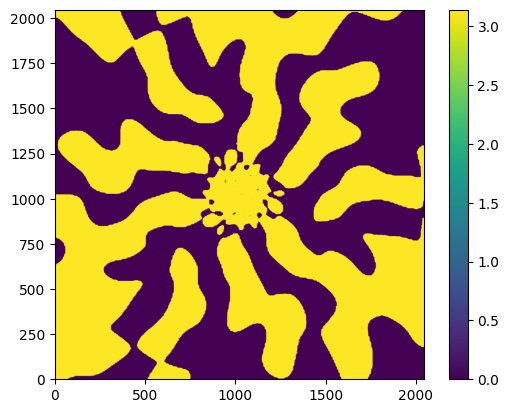

In [3]:
# testing toliman pupil layer
plt.imshow(dlT.TolimanPupilLayer(2048).phase,origin='lower')
plt.colorbar()
plt.show()

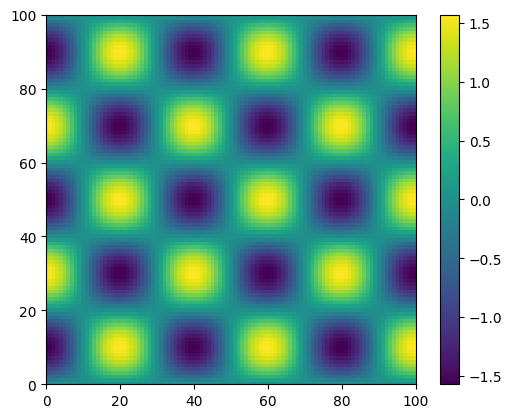

In [4]:
# testing phase grating layer
plt.imshow(dlT.PhaseGratingLayer(2048*2*2*2, 0.125, 304e-6, np.pi, True).phase,origin='lower')
plt.colorbar()
plt.xlim(0,100)
plt.ylim(0,100)
plt.show()

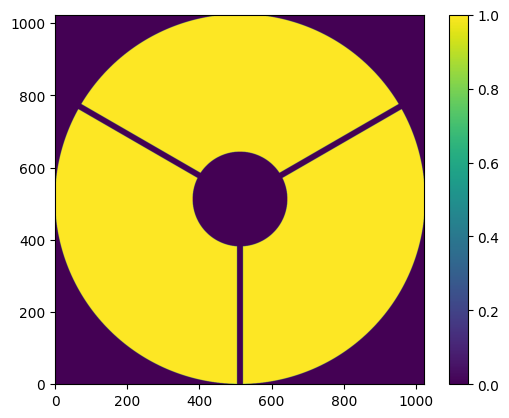

In [5]:
plt.imshow(dlT.TolimanApertureLayer(1024).transmission,origin='lower')
plt.colorbar()
plt.show()

In [6]:
# nice... all my classes work.

# let's make a telescope with a phase grating. 2048 resolution
# note: higher resolution, despite the fact that we're just calling from a file, takes forever
# it seems wrapping it the 'layer' object is the big issue
wf_npixels = 4096 # highest resolution without crashing
diameter = 0.125
period = diameter/128
difference = np.pi

apertureLayer = dlT.TolimanApertureLayer(wf_npixels)
gratingLayer = dlT.PhaseGratingLayer(wf_npixels,diameter,period,difference,False)
gratingLayerTol = dlT.PhaseGratingLayer(wf_npixels,diameter,period,difference,True)
pupilLayer = dlT.TolimanPupilLayer(wf_npixels)

layers = [
    (
        'aperture',
        apertureLayer
    ),
    (
        'grating',
        gratingLayer
    )
]

layersTol = [
    (
        'aperture',
        apertureLayer
    ),
    (
        'grating',
        gratingLayerTol
    ),
    (
        'pupil',
        pupilLayer
    )
]

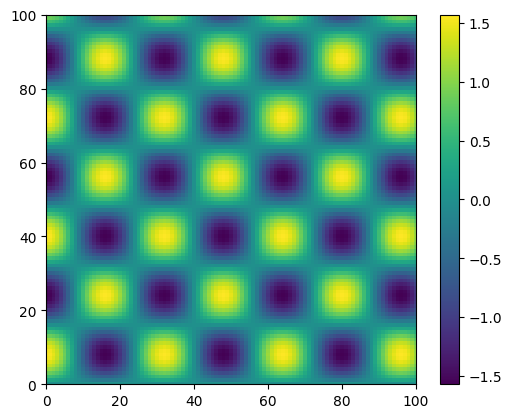

In [7]:
plt.imshow(gratingLayer.phase, origin='lower')
plt.xlim(0,100)
plt.ylim(0,100)
plt.colorbar()
plt.show()
# not all that high res with wf_npix at 2048, try 4096

In [8]:
psf_npixels = 512
pixel_scale = 1 
oversample = 8 # high level oversample

optics = dl.AngularOpticalSystem(wf_npixels,diameter,layers,psf_npixels,pixel_scale,oversample)
opticsTol = dl.AngularOpticalSystem(wf_npixels,diameter,layersTol,psf_npixels,pixel_scale,oversample)

988.48706


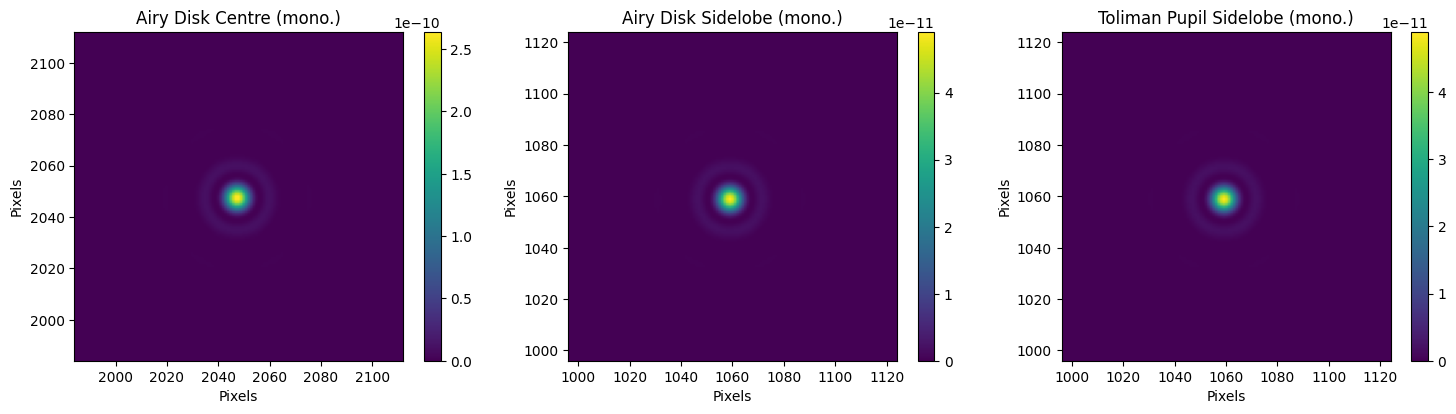

In [9]:
wavelength = 585e-9

psf = optics.propagate_mono(wavelength)
psfTol = opticsTol.propagate_mono(wavelength)

# Getting the offset of the sidelobes:
angles = np.arcsin(wavelength/period)

true_pixel_scale = dlu.arcsec2rad(pixel_scale/oversample)

# whole number divisible.
print(angles / true_pixel_scale)
centre_offset = angles // true_pixel_scale


# just centre of psf coords
centre = psf_npixels*oversample/2

# radius
radius = 8*oversample

plt.figure(figsize=(15, 4))

plt.subplot(1,3,1)
plt.imshow((psf), origin='lower')
plt.colorbar()
plt.title('Airy Disk Centre (mono.)')
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.xlim(centre - radius,centre + radius)
plt.ylim(centre - radius,centre + radius)


plt.subplot(1,3,2)
# Define the limits
x_min, x_max = int(centre - centre_offset - radius), int(centre - centre_offset + radius)
y_min, y_max = int(centre - centre_offset - radius), int(centre - centre_offset + radius)

# Extract the subset of the image within the limits
psf_subset = psf[y_min:y_max, x_min:x_max]

# Get the maximum value within this region
vmax_value = np.max(psf_subset)
plt.imshow((psf), origin='lower',vmax=vmax_value)
plt.colorbar()
plt.title('Airy Disk Sidelobe (mono.)')
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.xlim(centre - centre_offset - radius,centre - centre_offset + radius)
plt.ylim(centre - centre_offset - radius,centre - centre_offset + radius)

plt.subplot(1,3,3)
# Define the limits
x_min, x_max = int(centre - centre_offset - radius), int(centre - centre_offset + radius)
y_min, y_max = int(centre - centre_offset - radius), int(centre - centre_offset + radius)

# Extract the subset of the image within the limits
psfTol_subset = psfTol[y_min:y_max, x_min:x_max]

# Get the maximum value within this region
vmax_value = np.max(psfTol_subset)
plt.imshow((psfTol), origin='lower',vmax=vmax_value)
plt.colorbar()
plt.title('Toliman Pupil Sidelobe (mono.)')
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.xlim(centre - centre_offset - radius,centre - centre_offset + radius)
plt.ylim(centre - centre_offset - radius,centre - centre_offset + radius)

plt.tight_layout()
plt.show()

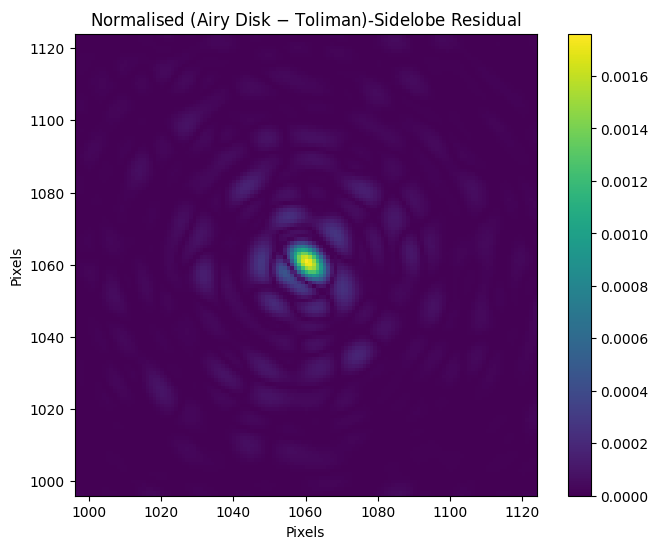

In [10]:
# Moral of the story: correctly calibrated, the phase grating basically gives the same image (airy disk + aperture)
# But: WAY DIMMER! each time.
# and offset as well. offset effects probably reduced for higher and higher oversample?

# try ary disk sidelobe - toliman pupil sidelobe:
plt.figure(figsize=(8,6))
# Define the limits
x_min, x_max = int(centre - centre_offset - radius), int(centre - centre_offset + radius)
y_min, y_max = int(centre - centre_offset - radius), int(centre - centre_offset + radius)

# Extract the subset of the image within the limits
sidelobe_max = np.max(psf[y_min:y_max, x_min:x_max])
psf_residual = np.abs((psf-psfTol))/sidelobe_max


# NORMalised residual subset
residual_subset = psf_residual[y_min:y_max, x_min:x_max]

# Get the maximum value within this region
vmax_value = np.max(residual_subset)
plt.imshow(psf_residual, origin='lower',vmax=vmax_value)
plt.colorbar()
plt.title('Normalised (Airy Disk $-$ Toliman)-Sidelobe Residual')
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.xlim(centre - centre_offset - radius,centre - centre_offset + radius)
plt.ylim(centre - centre_offset - radius,centre - centre_offset + radius)
plt.show()

In [11]:
# THINGS TO NOTE:

# MAXIMUM (normalised) DIFFERENCE BETWEEN TOLIMAN SIDELOBE AND AIRY DISK SIDELOBE
# DOESN'T SEEM TO CHANGE WITH BETTER RESOLUTION (i.e more oversampled) PSF 
# (unless it really poorly sampled)
# keep oversampling 8-16. Gonna keep 8 because 16 take too long

# Might change with lower resolution wf_npixels: let's check
# at 4096 wf_npixles, max norm diff ~0.0018.
# at 2048 wf_npixles, max norm diff ~0.006.
# i.e. roughly 4x worse

# at 1024 wf_npixels, max norm diff ~0.0015?????? so better than for 2048 and 4096??
# 512: ~0.0013. rofl
# 256 and it finally fully breaks.
# try 8xxx wf_npixels:... and it crashes. looks like 4096 is the highest I can go.

In [29]:
# Now, try and model the sidelobes in the centre by introducing some sort of phase ramp
# Really want any residual here to be basically 0
# Don't forget to include the offset caused by pixel discretisation
# Based on my week 1 dLux reconstruction, we know that a source located at (x, y) in radians on the sky
# Is just a phase shift of 2pi/lambda * (X sinx + Y siny)
# Where X and Y are the aperture coordinates? Yes! In Meters.
# So, if we want to simulate the bottom left hand corner, 
# we need to phase shift the source up into the top right hand corner
# I'm therefore gonna construct a class which imparts the correct phase shift
# Taking in an argument for the corner, and a central wavelength,
# Which when added to the other layers simulates the sidelobe

# angle that central wavelength makes with phase grating
central_wavelength = 585e-9
psf_pixel_scale = pixel_scale
angle = np.arcsin(central_wavelength/period)

# true pixel scale (radians per pixel)
true_pixel_scale = dlu.arcsec2rad(psf_pixel_scale/oversample)

# central offset (pixels, integer) --> radians
x_centre_offset = (angle // true_pixel_scale) * true_pixel_scale
y_centre_offset = (angle // true_pixel_scale) * true_pixel_scale

coords = dlu.pixel_coords(1*wf_npixels, diameter)

# phase shift
# negative phase shift is bottom left
# positive phase shift is top right

phase_shift = (2 * np.pi / central_wavelength) * (coords[0] * -np.sin(x_centre_offset) + coords[1] * np.sin(y_centre_offset)) #(2*np.pi)
# BOTTOM RIGHT
# phase_shift = (-2 * np.pi / central_wavelength) * (coords[0] * -np.sin(x_centre_offset) + coords[1] * np.sin(y_centre_offset)) #% (2*np.pi)

# TOP RIGHT
# phase_shift = (-2 * np.pi / central_wavelength) * (coords[0] * -np.sin(x_centre_offset) + coords[1] * -np.sin(y_centre_offset)) #% (2*np.pi)

# BOTTOM LEFT
# phase_shift = (2 * np.pi / central_wavelength) * (coords[0] * -np.sin(x_centre_offset) + coords[1] * -np.sin(y_centre_offset)) #% (2*np.pi)

# TOP LEFT
# phase_shift = (2 * np.pi / central_wavelength) * (coords[0] * -np.sin(x_centre_offset) + coords[1] * +np.sin(y_centre_offset)) #% (2*np.pi)

phase_shift_final = dlu.combine([phase_shift],1)

phase_shift_layer = dl.AberratedLayer(phase=phase_shift_final)

layersShift = [
    (
        'shift',
        phase_shift_layer
    ),
    (
        'aperture',
        apertureLayer
    ),
    # (
    #     'pupil',
    #     pupilLayer
    # ),
    (
        'grating',
        gratingLayer # Tol
    )
]
psf_npixels_lobe = 4
opticsShift = dl.AngularOpticalSystem(wf_npixels,diameter,layersShift,psf_npixels_lobe,pixel_scale,oversample)
psfShift = opticsShift.propagate_mono(wavelength)

988.48706


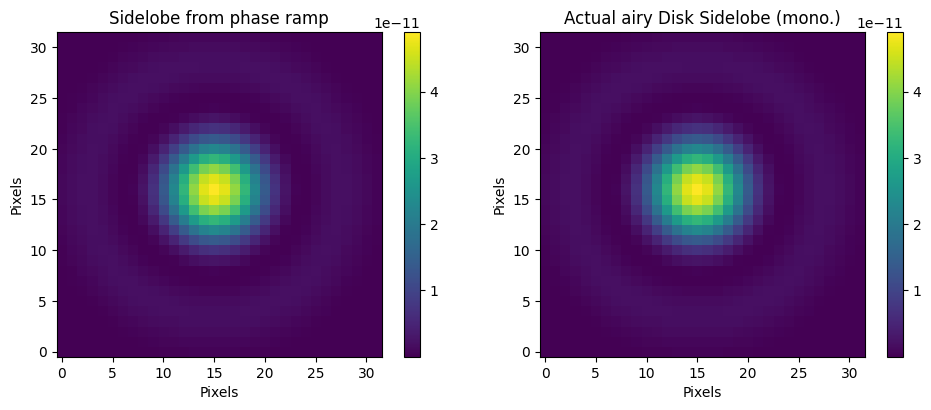

In [30]:

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title('Sidelobe from phase ramp')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
# plt.xlim(-.0,16)
# plt.ylim(0,16)
plt.imshow((psfShift), origin='lower')
plt.colorbar()

plt.subplot(1,2,2)
# Getting the offset of the sidelobes:
angles = np.arcsin(wavelength/period)

true_pixel_scale = dlu.arcsec2rad(pixel_scale/oversample)

# whole number divisible.
print(angles / true_pixel_scale)
centre_offset = angles // true_pixel_scale


# just centre of psf coords
centre = psf_npixels*oversample/2

# radius
radius = 2*oversample
# Define the limits
x_min, x_max = int(centre - centre_offset - radius), int(centre - centre_offset + radius)
y_min, y_max = int(centre + centre_offset - radius), int(centre + centre_offset + radius)

# Extract the subset of the image within the limits
psf_subset = psf[y_min:y_max, x_min:x_max]

# Get the maximum value within this region
vmax_value = np.max(psf_subset)
plt.imshow((psf_subset), origin='lower',vmax=(vmax_value))
plt.colorbar()
plt.title('Actual airy Disk Sidelobe (mono.)')
plt.xlabel("Pixels")
plt.ylabel("Pixels")
# plt.xlim(centre + centre_offset - radius - 0.5,centre + centre_offset + radius - 0.5)
# plt.ylim(centre + centre_offset - radius - 0.5,centre + centre_offset + radius - 0.5)

plt.tight_layout()
plt.show()

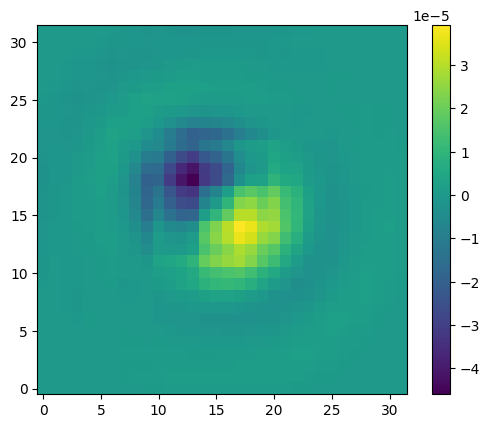

In [31]:
plt.imshow((psf_subset/vmax_value - psfShift/np.max(psfShift)),origin='lower')
plt.colorbar()
plt.show()

# NOTE: Similar with tol and normal (airy) psf! As required!

In [ ]:
# Now... want some way to simulate an entire sidelobe.
# Probably gonna have to create a new type of angular optical system
# Takes normal angular optical system inputs, e.g. layers
# Has to explicitly NOT take in the diffractive pupil layer
# Nor the phase grating layer
# The input should only be the transmissive layer (pretty much).
# Then, there is some function which takes in the sources, their positions and their wavelengths...
# And maps that to the airy disk in correct sidelobe location.
# BUT, first things first: monochromatic source in centre
# Need some way to map the flux of a central psf to the sidelobe flux
# Louis said: requires 'experimental mathematics'
